### ML3 HW3
#### LT5
Borromeo, Chloe<br>
Castanares, Michael Lawrence<br>
Garcia, Fernando Jude<br>
Tan, Allan

Assignment Instructions<br>
Done by LT<br>
Total: 12 points<br>
Submit: Python Notebook (.ipynb)<br>
Task (4pts each method)<br>
Hourly Energy Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region<br>

Using the PJM West Region: 2001-2018 (PJMW) estimated hourly energy consumption data from PJM in Megawatts: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data. Forecast the total daily consumption one month in advance. Compare the MAE and MAPE accuracy of the best:<br><br>
ARIMA<br>
LSTM<br>
GRU<br>

### Load the data

In [2]:
import pandas as pd

In [3]:
file = 'data/PJMW_hourly.csv'

In [4]:
df = pd.read_csv(file)
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [5]:
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


Resample to get daily consumption

In [56]:

df.index = pd.to_datetime(df['Datetime'])
df_daily = df.resample('D').sum('PJMW_MW')


# # # Remove Aug 3 2018 because it does not have a complete day's worth of data

df_daily = df_daily[:-1]

In [7]:
df_daily.describe()

,PJMW_MW
count,5968.000000
mean,134431.675268
std,17722.294237
min,72433.000000
25%,121031.750000
50%,132522.500000
75%,146056.500000
max,211070.000000


### 1. ARIMA

In [8]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


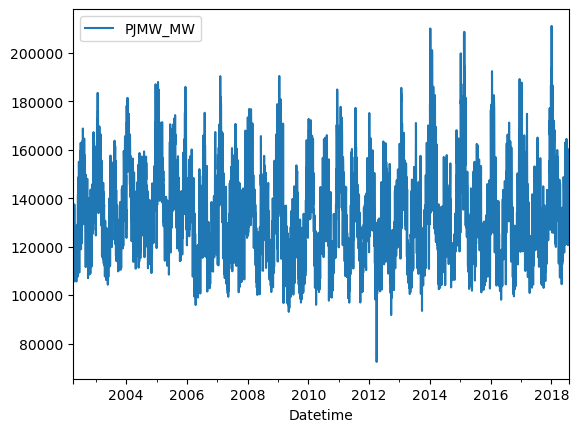

In [9]:
from matplotlib import pyplot
%matplotlib inline
df_daily.plot()
pyplot.show()

The data needs to be stationary for ARIMA to work. Let's check that.

In [10]:
# ! conda install statsmodels -y

In [11]:
from statsmodels.tsa.stattools import adfuller

series = df_daily['PJMW_MW']
# Perform the ADF test to check stationarity
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.264578
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The results show that the test statistic value -7.264578 is smaller than the critical value at 1% of -3.431. This suggests the process has no unit root, and in turn that **the time series is stationary or does not have time-dependent structure**.

In [12]:
# ! conda install scikit-learn -y

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm 
import timeit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# Create a differenced series
def difference(dataset, interval=1):
    diff = np.diff(dataset, n=interval)
    return diff

# Invert differenced value
def inverse_difference(history, yhat, interval=1):
   return yhat + history[-interval]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    #X = X.astype('float32')
    days_in_a_month = 30  # Define the number of days in a month
    train_size = int(len(X) - days_in_a_month)  # Use 1 month validation
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #history = list(train)


    # Make predictions
    predictions = list()
    for t in tqdm(range(len(test))):
        # Difference data
        diff = difference(history, days_in_a_month)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        yhat = forecast.predicted_mean[0]
        yhat = inverse_difference(history, yhat, days_in_a_month)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Calculate out-of-sample error (MAE)
    mae = mean_absolute_error(test, predictions)
    return mae


In [14]:
X = series.values
start = timeit.default_timer()
mar = evaluate_arima_model(X, (0, 0, 1))
exec_time = timeit.default_timer() - start
print(f'MAE={mar} Execution Time: {exec_time}')


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]

MAE=10424.651074160976 Execution Time: 8.717013604997192


Do GridSearch to find the optimal values of p,d and q

In [15]:
from itertools import product

# Define ranges for p, d, q
p_range = range(0, 6)
d_range = range(0, 1)
q_range = range(0, 6)

# Initialize a dictionary to store the results
results = {}
start = timeit.default_timer()
# Iterate over all combinations of p, d, q
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    # Evaluate the ARIMA model for the current (p, d, q) order
    try:
        mae = evaluate_arima_model(X, order)
        # Store the result in the dictionary
        results[order] = mae
        print(f"Order {order}, MAE: {mae}")
    except:
        print(f"Error trying to converge Order {order}")

# Find the (p, d, q) combination with the lowest RMSE
best_order = min(results, key=results.get)
best_mae = results[best_order]
exec_time = timeit.default_timer() - start
# Print the best (p, d, q) combination and the corresponding RMSE
print(f"\nBest Order: {best_order}, Lowest MAE: {best_mae}, Execution Time: {exec_time}")

100%|██████████| 30/30 [00:01<00:00, 20.95it/s]


Order (0, 0, 0), MAE: 17598.907950293655


100%|██████████| 30/30 [00:07<00:00,  3.90it/s]


Order (0, 0, 1), MAE: 10424.651074160976


100%|██████████| 30/30 [00:31<00:00,  1.03s/it]


Order (0, 0, 2), MAE: 9625.625723790323


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


Order (0, 0, 3), MAE: 9585.596543090682


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


Order (0, 0, 4), MAE: 8897.637914831234


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Order (0, 0, 5), MAE: 8934.78485969566


100%|██████████| 30/30 [00:04<00:00,  7.14it/s]


Order (1, 0, 0), MAE: 10334.838408652991


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


Order (1, 0, 1), MAE: 9070.25080983792


100%|██████████| 30/30 [00:19<00:00,  1.57it/s]


Order (1, 0, 2), MAE: 9041.101670015703


100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


Order (1, 0, 3), MAE: 9001.971890460445


100%|██████████| 30/30 [00:45<00:00,  1.50s/it]


Order (1, 0, 4), MAE: 8973.3738157551


100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


Order (1, 0, 5), MAE: 9225.577130929052


100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


Order (2, 0, 0), MAE: 10295.519031642416


100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


Order (2, 0, 1), MAE: 9076.007531218487


100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


Order (2, 0, 2), MAE: 9087.719347375996


100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


Order (2, 0, 3), MAE: 8968.575385477905


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:04<02:04,  4.31s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:08<01:57,  4.19s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:12<01:51,  4.11s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (2, 0, 4), MAE: 8992.884249130952


100%|██████████| 30/30 [01:21<00:00,  2.73s/it]


Order (2, 0, 5), MAE: 9223.871763251636


100%|██████████| 30/30 [00:06<00:00,  4.42it/s]


Order (3, 0, 0), MAE: 9351.821697809206


100%|██████████| 30/30 [00:19<00:00,  1.57it/s]


Order (3, 0, 1), MAE: 8827.395121479298


100%|██████████| 30/30 [00:53<00:00,  1.80s/it]


Order (3, 0, 2), MAE: 9606.867407377165


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:08<01:54,  4.08s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:12<01:48,  4.02s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 13%|█▎        | 4/30 [00:15<01:41,  3.92s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (3, 0, 3), MAE: 9529.579325789511


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:05<02:35,  5.36s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:10<02:23,  5.12s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:15<02:17,  5.09s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (3, 0, 4), MAE: 8819.607864454594


 13%|█▎        | 4/30 [00:31<03:28,  8.04s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 20%|██        | 6/30 [00:45<03:01,  7.55s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 7/30 [00:52<02:47,  7.29s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 27%|██▋       | 8/30 [00:58<02:33,  6.98s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:

Order (3, 0, 5), MAE: 9282.320895163399


100%|██████████| 30/30 [00:08<00:00,  3.58it/s]


Order (4, 0, 0), MAE: 8866.708363781783


100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


Order (4, 0, 1), MAE: 8697.733765846935


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:04<02:02,  4.22s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:08<01:58,  4.22s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:12<01:53,  4.22s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (4, 0, 2), MAE: 9239.524305146728


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:04<02:13,  4.60s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:09<02:10,  4.68s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:14<02:07,  4.71s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (4, 0, 3), MAE: 8985.341204112943


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:05<02:38,  5.46s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:11<02:44,  5.86s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:16<02:31,  5.60s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (4, 0, 4), MAE: 8767.161605731748


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:05<02:51,  5.92s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:12<02:53,  6.21s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:19<02:58,  6.61s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (4, 0, 5), MAE: 8815.00643086544


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


Order (5, 0, 0), MAE: 8482.58507352798


100%|██████████| 30/30 [01:34<00:00,  3.16s/it]


Order (5, 0, 1), MAE: 8650.375368059797


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:05<02:34,  5.32s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:11<02:35,  5.57s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:15<02:22,  5.28s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (5, 0, 2), MAE: 8573.232510263762


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:05<02:37,  5.42s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:10<02:32,  5.44s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:16<02:23,  5.32s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (5, 0, 3), MAE: 8521.561617246982


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:05<02:48,  5.80s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:11<02:38,  5.68s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:16<02:32,  5.63s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (5, 0, 4), MAE: 9538.338866654516


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:06<03:09,  6.54s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:12<02:56,  6.29s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:18<02:45,  6.13s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (5, 0, 5), MAE: 9030.204243280994

Best Order: (5, 0, 0), Lowest MAE: 8482.58507352798, Execution Time: 2654.1316702099866


### 2. LSTM

In [16]:
import torch
import torch.nn as nn
pytorch_gpu_available = torch.cuda.is_available()
print(f"GPU (CUDA) is available: {pytorch_gpu_available}")
if pytorch_gpu_available:
    print(f"Number of available GPUs: {torch.cuda.device_count()}")


GPU (CUDA) is available: True
Number of available GPUs: 1


In [17]:
from torch.utils.data import Dataset, DataLoader

In [80]:
# convert dates into epoch seconds
df_daily['Time'] = (df_daily.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
normalized_data = df_daily[['Time', 'PJMW_MW']]
normalized_data.reset_index(inplace=True, drop=True)
normalized_data.head()

,Time,PJMW_MW
0,1017619200,121237.0
1,1017705600,127450.0
2,1017792000,127822.0
3,1017878400,136099.0
4,1017964800,136467.0


Normalize the data<br>
Training data is 0-80%<br>
Validation Data is 80-90%<br>
Test Data is last 10%

In [ ]:
cutoff_train = int(len(df_daily) * 0.8)
cutoff_val = int(len(df_daily) * 0.9)

# Normalize data based on the training set
mean = normalized_data['PJMW_MW'][:cutoff_train].mean(axis=0)
std = normalized_data['PJMW_MW'][:cutoff_train].std(axis=0)
normalized_data['PJMW_MW'] = (normalized_data['PJMW_MW'] - mean) / std
normalized_data = normalized_data.to_numpy()


In [85]:
from torch.utils.data import Dataset

class PJMWBDataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.min_index = min_index
        self.max_index = max_index if max_index is not None else len(data) - delay - 1
        self.step = step

    def __len__(self):
        return self.max_index - self.min_index - self.lookback + 1

    def __getitem__(self, index):
        i = self.min_index + index + self.lookback
        indices = range(i - self.lookback, i, self.step)
        samples = self.data[indices]
        target = self.data[i + self.delay][-1]  # last column column (index -1) is the target variable

        return torch.tensor(samples, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)




Look back 120 days, 1 data point per day, predict the next 30th day

In [ ]:
NUM_WORKERS = 1

lookback = 120 # 120 days
step = 1
delay = 30 * 2 # predict next 30 days
batch_size = 120

train_dataset = PJMWBDataset(normalized_data, lookback, delay, 0, cutoff_train, step)
val_dataset = PJMWBDataset(normalized_data, lookback, delay, cutoff_train + 1, cutoff_val, step)
test_dataset = PJMWBDataset(normalized_data, lookback, delay, cutoff_val + 1, None, step)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)



In [22]:
# import numpy as np

# def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
#     # print(f'DATA SHAPE={data.shape}')
#     # Set default max_index if not provided
#     if max_index is None:
#         max_index = len(data) - delay - 1

#     # Start index for data sampling
#     i = min_index + lookback

#     # Infinite loop to generate samples indefinitely
#     while True:
#         # Shuffle data if required; otherwise, generate sequential batches
#         if shuffle:
#             rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
#             # print(f'ROWS SHAPE={rows.shape}')
#         else:
#             if i + batch_size >= max_index:
#                 i = min_index + lookback  # Reset index if it goes beyond the max index
#             rows = np.arange(i, min(i + batch_size, max_index))
#             # print(f'ROWS SHAPE={rows.shape}')
#             i += len(rows)

#         # Initialize numpy arrays to store samples and targets
#         # samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
#         samples = np.zeros((len(rows), lookback // step))
#         targets = np.zeros((len(rows),))

#         # Populate samples and targets arrays
#         for j, row in enumerate(rows):
#             indices = range(rows[j] - lookback, rows[j], step)  # Select indices for sample
#             # indices = range(rows[j], step)  # Select indices for sample
#             samples[j] = data[indices]  # Assign the sliced data to samples
#             targets[j] = data[rows[j] + delay]  # Set the corresponding target

#         # Yield a batch of samples and targets
#         print(f'SAMPLES {samples.shape} TARGETS {targets.shape}')
#         yield samples, targets


In [23]:
# lookback = 30 * 6 # 3 months
# step = 1
# delay = 30
# batch_size = lookback // step #Each of the batch will have inputs = lookback/step (240 hours in this example) +  delay/step (24 hours)

# train_cutoff = int(len(X) * 0.7)
# val_cutoff = int(len(X) * 0.8)
# test_cutoff = int(len(X) * 0.9)

# train_gen = generator(X,
#     lookback=lookback,
#     delay=delay,
#     min_index=0,
#     max_index=train_cutoff,
#     shuffle=True,
#     step=step,
#     batch_size=batch_size)

# val_gen = generator(X,
#     lookback=lookback, 
#     delay=delay,
#     min_index=train_cutoff +1,
#     max_index=val_cutoff,
#     shuffle=False,
#     step=step,
#     batch_size=batch_size)

# test_gen = generator(X,
#     lookback=lookback,
#     delay=delay,
#     min_index=val_cutoff + 1,
#     max_index=None,
#     step=step,
#     batch_size=batch_size)

# val_steps = (test_cutoff - val_cutoff + 1 - lookback)  #How many steps to draw from val_gen in order to see the entire
#                                           #validation set ---
#                                          #This is normally a problem in keras so let's manually set this to just 1000
# test_steps = (len(X) - test_cutoff - lookback)  #How many steps to draw from test_gen in order to see the
#                                           #entire test set

# print(f'TEST STEPS {test_steps}')
# print(f'VAL STEPS {val_steps}')

Baseline - Naive Model

In [94]:
def evaluate_naive_method(loader):
    maes = []
    for samples, targets in loader:
        preds = samples[:, -1 , 1]  # last time step's temperature as prediction
        # print(f'SAMPLES {samples.shape} PREDS {preds.shape} TARGETS {targets.shape}')
        mae = torch.mean(torch.abs(preds - targets))
        maes.append(mae.item())
    return np.mean(maes)

# Evaluate
naive_mae = evaluate_naive_method(val_loader)
print(f"Naive method MAE on validation set: {naive_mae}")

Naive method MAE on validation set: 1.3588061332702637


Feed Forward Neural Net

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_shape[0] * input_shape[1], 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Determine input shape based on your data structure
input_shape = (lookback // step, normalized_data.shape[-1])
model = Net(input_shape)

# Print model architecture
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [120]:
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(1, input_shape[0], input_shape[1]), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Flatten: 1-1                           [1, 240]                  --
├─Linear: 1-2                            [1, 32]                   7,712
├─ReLU: 1-3                              [1, 32]                   --
├─Linear: 1-4                            [1, 1]                    33
Total params: 7,745
Trainable params: 7,745
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [121]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 263706552.5459, Val Loss: 0.8499
Epoch 2/20, Train Loss: 0.8099, Val Loss: 0.8495
Epoch 3/20, Train Loss: 0.8097, Val Loss: 0.8499
Epoch 4/20, Train Loss: 0.8101, Val Loss: 0.8501
Epoch 5/20, Train Loss: 0.8098, Val Loss: 0.8496
Epoch 6/20, Train Loss: 0.8091, Val Loss: 0.8501
Epoch 7/20, Train Loss: 0.8099, Val Loss: 0.8501
Epoch 8/20, Train Loss: 0.8089, Val Loss: 0.8506
Epoch 9/20, Train Loss: 0.8098, Val Loss: 0.8502
Epoch 10/20, Train Loss: 0.8096, Val Loss: 0.8508
Epoch 11/20, Train Loss: 0.8090, Val Loss: 0.8493
Epoch 12/20, Train Loss: 0.8096, Val Loss: 0.8498
Epoch 13/20, Train Loss: 0.8098, Val Loss: 0.8501
Epoch 14/20, Train Loss: 0.8097, Val Loss: 0.8510
Epoch 15/20, Train Loss: 0.8097, Val Loss: 0.8516
Epoch 16/20, Train Loss: 0.8095, Val Loss: 0.8514
Epoch 17/20, Train Loss: 0.8096, Val Loss: 0.8495
Epoch 18/20, Train Loss: 0.8101, Val Loss: 0.8500
Epoch 19/20, Train Loss: 0.8093, Val Loss: 0.8517
Epoch 20/20, Train Loss: 0.8093, Val Loss: 0.8

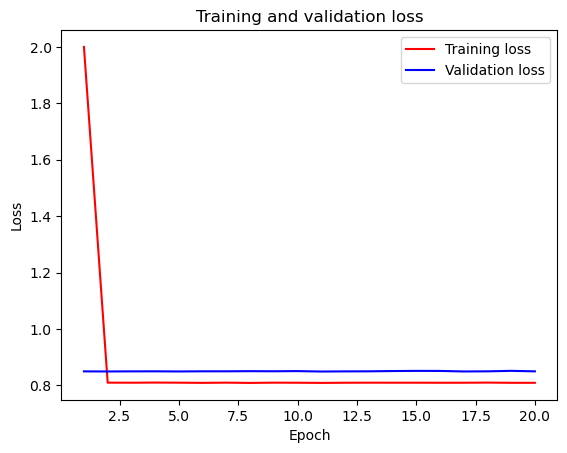

In [122]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

LSTM

In [107]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        # LSTM Layer:
        # - 32 units, as in the Keras model
        # - input_size is the number of features
        self.lstm = nn.LSTM(input_size, 32, batch_first=True)
        # Dense Layer:
        # - 32 (from LSTM) to 1 output (since we're predicting one value)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, features)
        lstm_out, _ = self.lstm(x)
        # We only care about the last output of LSTM for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            lstm_out = lstm_out[:, -1, :]  # Take last time step
        else:  # If not batched
            lstm_out = lstm_out[-1, :]  # Take last time step

        # Pass through dense layer
        output = self.dense(lstm_out)
        return output

# Define the model with the right input size
input_size = 2  # Number of features in your data
model = LSTMModel(input_size)

# Print model summary
print(model)

# If you want to see the number of parameters:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

LSTMModel(
  (lstm): LSTM(2, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 4641


In [109]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 0.8146, Val Loss: 0.8490
Epoch 2/20, Train Loss: 0.8113, Val Loss: 0.8523
Epoch 3/20, Train Loss: 0.8102, Val Loss: 0.8481
Epoch 4/20, Train Loss: 0.8119, Val Loss: 0.8486
Epoch 5/20, Train Loss: 0.8116, Val Loss: 0.8709
Epoch 6/20, Train Loss: 0.8112, Val Loss: 0.8482
Epoch 7/20, Train Loss: 0.8102, Val Loss: 0.8482
Epoch 8/20, Train Loss: 0.8109, Val Loss: 0.8529
Epoch 9/20, Train Loss: 0.8106, Val Loss: 0.8510
Epoch 10/20, Train Loss: 0.8118, Val Loss: 0.8522
Epoch 11/20, Train Loss: 0.8114, Val Loss: 0.8492
Epoch 12/20, Train Loss: 0.8100, Val Loss: 0.8489
Epoch 13/20, Train Loss: 0.8108, Val Loss: 0.8555
Epoch 14/20, Train Loss: 0.8120, Val Loss: 0.8484
Epoch 15/20, Train Loss: 0.8113, Val Loss: 0.8481
Epoch 16/20, Train Loss: 0.8108, Val Loss: 0.8548
Epoch 17/20, Train Loss: 0.8110, Val Loss: 0.8511
Epoch 18/20, Train Loss: 0.8093, Val Loss: 0.8527
Epoch 19/20, Train Loss: 0.8108, Val Loss: 0.8550
Epoch 20/20, Train Loss: 0.8115, Val Loss: 0.8533


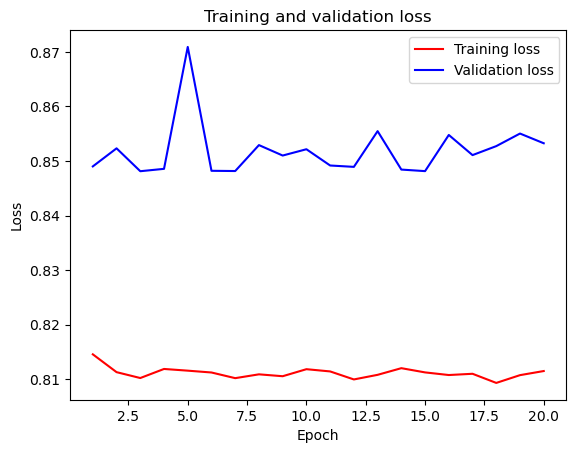

In [110]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 3. GRU

In [111]:

class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, 32, batch_first=True)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # GRU expects input of shape (batch_size, sequence_length, features)
        gru_out, _ = self.gru(x)
        # We only care about the last output of GRU for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            gru_out = gru_out[:, -1, :]  # Take last time step
        else:  # If not batched
            gru_out = gru_out[-1, :]  # Take last time step

        output = self.dense(gru_out)
        return output

# Define the model with the right input size
input_size = 2
model = GRUModel(input_size)

# Print model summary
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

GRUModel(
  (gru): GRU(2, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 3489


In [112]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 0.8285, Val Loss: 0.8482
Epoch 2/20, Train Loss: 0.8168, Val Loss: 0.8494
Epoch 3/20, Train Loss: 0.8153, Val Loss: 0.8491
Epoch 4/20, Train Loss: 0.8099, Val Loss: 0.8557
Epoch 5/20, Train Loss: 0.8135, Val Loss: 0.8550
Epoch 6/20, Train Loss: 0.8117, Val Loss: 0.8511
Epoch 7/20, Train Loss: 0.8136, Val Loss: 0.8520
Epoch 8/20, Train Loss: 0.8163, Val Loss: 0.8485
Epoch 9/20, Train Loss: 0.8120, Val Loss: 0.8501
Epoch 10/20, Train Loss: 0.8137, Val Loss: 0.8517
Epoch 11/20, Train Loss: 0.8122, Val Loss: 0.8511
Epoch 12/20, Train Loss: 0.8131, Val Loss: 0.8485
Epoch 13/20, Train Loss: 0.8139, Val Loss: 0.8484
Epoch 14/20, Train Loss: 0.8122, Val Loss: 0.8526
Epoch 15/20, Train Loss: 0.8113, Val Loss: 0.8522
Epoch 16/20, Train Loss: 0.8139, Val Loss: 0.8494
Epoch 17/20, Train Loss: 0.8103, Val Loss: 0.8686
Epoch 18/20, Train Loss: 0.8145, Val Loss: 0.8629
Epoch 19/20, Train Loss: 0.8138, Val Loss: 0.8557
Epoch 20/20, Train Loss: 0.8129, Val Loss: 0.8769


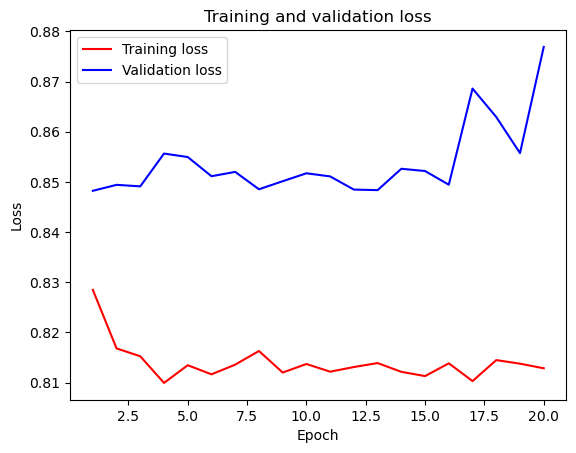

In [113]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Stack Recurrent Layers

In [114]:
class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        # First GRU Layer:
        self.gru1 = nn.GRU(input_size, 16, dropout=0.1, bidirectional=False, batch_first=True)
        # Here, we manually set recurrent_dropout using a custom wrapper
        self.gru1_dropout = nn.Dropout(0.2)

        # Second GRU Layer:
        self.gru2 = nn.GRU(16, 32, dropout=0.1, bidirectional=False, batch_first=True)
        self.gru2_dropout = nn.Dropout(0.2)

        # Dense Layer:
        self.dense = nn.Linear(32, 1)

        # Activation for the second GRU layer
        self.relu = nn.ReLU()

    def forward(self, x):
        # First GRU layer with recurrent dropout
        gru1_out, _ = self.gru1(x)
        gru1_out = self.gru1_dropout(gru1_out)

        # Second GRU layer
        gru2_out, _ = self.gru2(gru1_out)
        gru2_out = self.gru2_dropout(gru2_out)
        gru2_out = self.relu(gru2_out)

        # We take the last output of the sequence for prediction
        if x.dim() == 3:  # (batch, seq, feature)
            gru2_out = gru2_out[:, -1, :]  # Take last time step
        else:  # If not batched
            gru2_out = gru2_out[-1, :]  # Take last time step

        # Dense layer
        output = self.dense(gru2_out)
        return output

# Define the model with the right input size
input_size = 2  # Number of features in your data
model = GRUModel(input_size)

# Print model summary
print(model)

# If you want to see the number of parameters:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

GRUModel(
  (gru1): GRU(2, 16, batch_first=True, dropout=0.1)
  (gru1_dropout): Dropout(p=0.2, inplace=False)
  (gru2): GRU(16, 32, batch_first=True, dropout=0.1)
  (gru2_dropout): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)
Total parameters: 5793


In [115]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 0.8437, Val Loss: 0.8522
Epoch 2/20, Train Loss: 0.8163, Val Loss: 0.8552
Epoch 3/20, Train Loss: 0.8138, Val Loss: 0.8483
Epoch 4/20, Train Loss: 0.8135, Val Loss: 0.8486
Epoch 5/20, Train Loss: 0.8128, Val Loss: 0.8543
Epoch 6/20, Train Loss: 0.8113, Val Loss: 0.8491
Epoch 7/20, Train Loss: 0.8108, Val Loss: 0.8521
Epoch 8/20, Train Loss: 0.8102, Val Loss: 0.8495
Epoch 9/20, Train Loss: 0.8120, Val Loss: 0.8488
Epoch 10/20, Train Loss: 0.8090, Val Loss: 0.8510
Epoch 11/20, Train Loss: 0.8110, Val Loss: 0.8499
Epoch 12/20, Train Loss: 0.8104, Val Loss: 0.8529
Epoch 13/20, Train Loss: 0.8115, Val Loss: 0.8521
Epoch 14/20, Train Loss: 0.8106, Val Loss: 0.8491
Epoch 15/20, Train Loss: 0.8101, Val Loss: 0.8489
Epoch 16/20, Train Loss: 0.8092, Val Loss: 0.8501
Epoch 17/20, Train Loss: 0.8097, Val Loss: 0.8498
Epoch 18/20, Train Loss: 0.8100, Val Loss: 0.8496
Epoch 19/20, Train Loss: 0.8090, Val Loss: 0.8495
Epoch 20/20, Train Loss: 0.8099, Val Loss: 0.8491


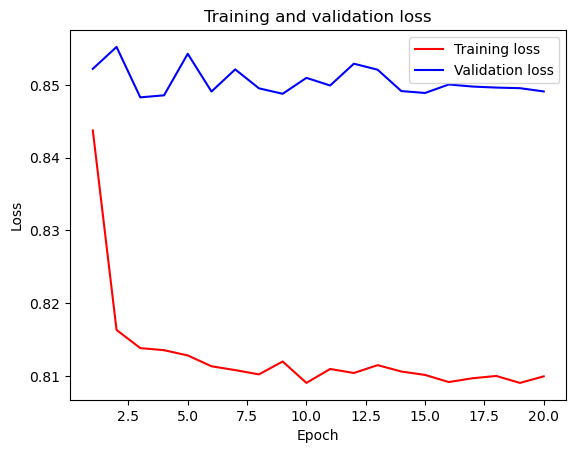

In [116]:
max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()